### Evaluación de modelo
Este notebook toma un modelo y lo evalúa sobre el dataset de *test* de CIFAR-10.

In [10]:
import matplotlib.pyplot as plt         # To show dataset images
import torch                            # To create the convolutional neural network
from torch import nn                    # To create the architecture of the convolutional neural network
from torch.utils.data import DataLoader # To create the dataloader
import torchvision                      # To manipulate the dataset
from torchvision import transforms      # To manipulate the dataset
from torch.nn import functional as F    # To use the activation functions


### Arquitectura de la red

In [11]:
batch_size = 64

# - Create the convolutional neural network -
class ConvNeuralNetwork(nn.Module):
    """
    Convolutional Neural Network Architecture
    to classify images from CIFAR-10 dataset.
    """

    def __init__(
        self,
        num_filters,
        kernel_size,
        num_layers,
        hidden_dim,
        dropout_prob,
        learning_decay,
        learning_rate=0.001,
        input_channels: int = 3,
        num_classes: int = 10,
    ):
        """
        Neural Network Architecture:
        - Convolutional Layer
        - ReLU Activation Function
        - Softmax Activation Function
        """
        super(ConvNeuralNetwork, self).__init__()
        # > Convolutional Layers
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=(
                        input_channels if i == 0 else num_filters * (2 ** (i - 1))
                    ),
                    out_channels=num_filters * (2**i),
                    kernel_size=kernel_size,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        self.output = nn.Linear(hidden_dim, num_classes)

        # > Activation Functions
        self.in_linear = num_filters * (2 ** (num_layers - 1)) * 4 * 4
        self.fc = nn.Linear(self.in_linear, hidden_dim)

        # > Dropout Layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout Layer to avoid overfitting

        # > Optimizer
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

        # > Loss and cost function
        self.loss = nn.CrossEntropyLoss()
        self.actual_loss = 0
        self.cost = []
        
        self.actual_corrects = 0
        self.acc = []

        # > Learning decay (useless for now)
        self.learning_decay = learning_decay

        self.epochs_printed = []

    def forward(self, x: torch.Tensor, showImg=False) -> torch.Tensor:
        """
        Forward pass of the neural network.
        If showImg is True, make a plot with the output of each convolutional layer
        in a row.
        """
        
        rowImages = []
        
        for conv in self.convs:
            x = F.relu(conv(x))
            if showImg:
                rowImages.append(x.cpu())
            x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.in_linear)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.output(x)
        
        # Show the images after the convolutional layers
        if showImg:
            fig, ax = plt.subplots(1, len(rowImages), figsize=(10, 1))
            for i in range(len(rowImages)):
                ax[i].set_axis_off()
                ax[i].imshow(rowImages[i][0][0].detach().numpy(), cmap="PRGn")
            plt.show()
        
        return x

    def backward(self, x: torch.Tensor, y: torch.Tensor, epoch: int) -> float:
        """
        Backward pass of the neural network.
        - Calculate the loss
        - Calculate the gradients
        - Update the weights
        """

        # Get the predictions
        y_pred = self.forward(x, showImg=epoch not in self.epochs_printed)
        self.epochs_printed.append(epoch)

        # Optimize the weights
        loss = self.loss(y_pred, y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        # Take highest value as prediction
        _, y_pred = torch.max(y_pred, dim=1)
        self.actual_corrects += torch.sum(y_pred == y)

        # Accumulate the loss
        self.actual_loss += loss.item()

        return loss.item()

    def train(self, train_dataloader: DataLoader, epochs: int = 10) -> None:
        """
        Train the neural network.
        """
        for epoch in range(epochs):
            self.actual_loss = 0
            self.actual_corrects = 0
            
            for batch in train_dataloader:
                x, y = batch
                self.actual_loss += self.backward(x, y, epoch)

            self.acc.append(self.actual_corrects / (len(train_dataloader) * batch_size))
            self.cost.append(self.actual_loss / (len(train_dataloader) * batch_size))
            print(f"Epoch {epoch + 1} - Cost: {self.cost[-1]:.4f} | Acc: {self.acc[-1]:.4f}")



### Cargar modelo
Una vez con la definición de la clase de la red neuronal, se carga el modelo con los parámetros de la red entrenada

In [12]:
# Load the model
model = torch.load('cnn-cifar10.pt')

# Create a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dictionary of class names
labels = test_dataset.classes
label2id, id2label = {}, {}
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
print(f'{label2id=}')
print(f'{id2label=}')

Files already downloaded and verified
label2id={'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
id2label={0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


### Análisis de los resultados

#### Creación de la matriz de confusión
Para el *dataset* de test, se revisan los *labels* en comparación con la predicción de la red, para así armar la matriz de confusión.
Para las primeras 10 imágenes se muestran las salidas de las capas al aplicar *forward*.

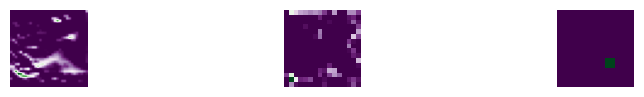

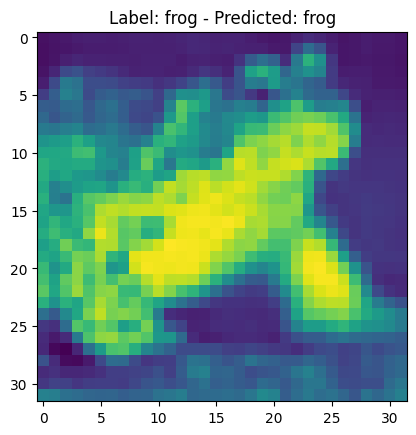

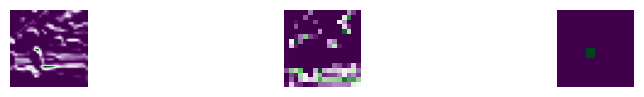

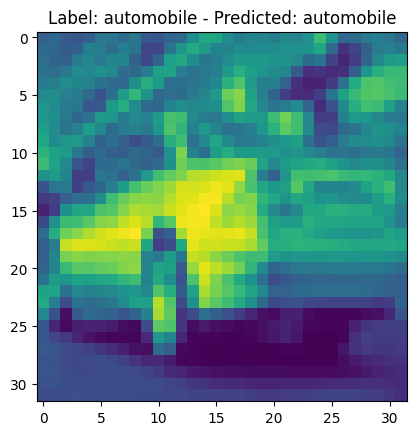

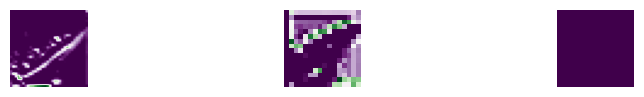

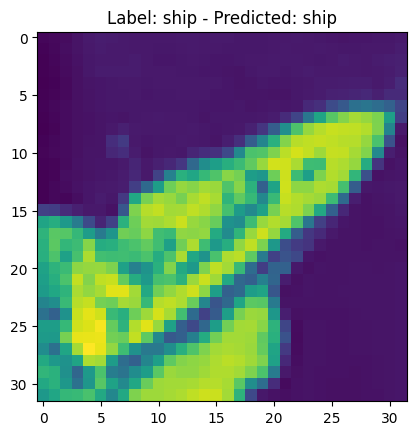

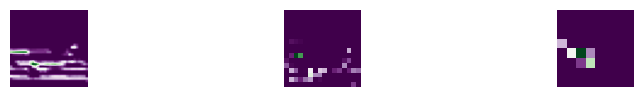

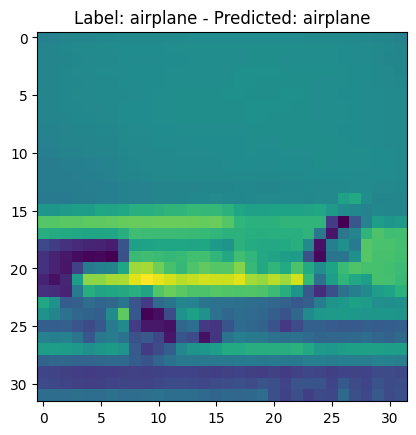

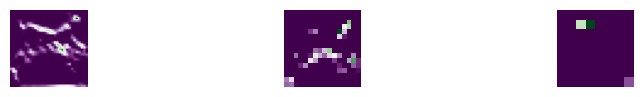

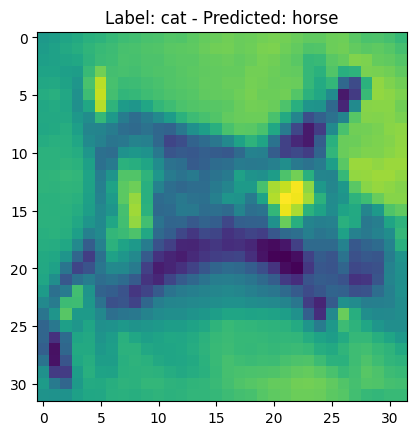

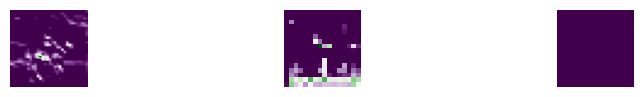

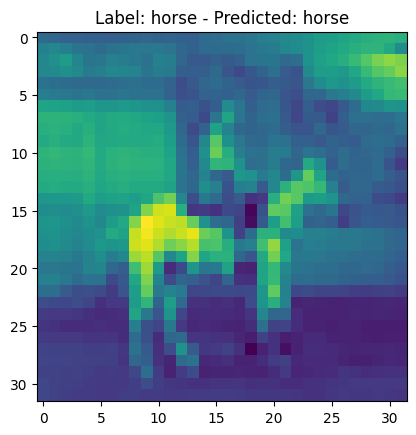

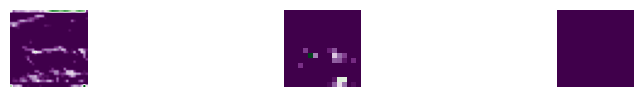

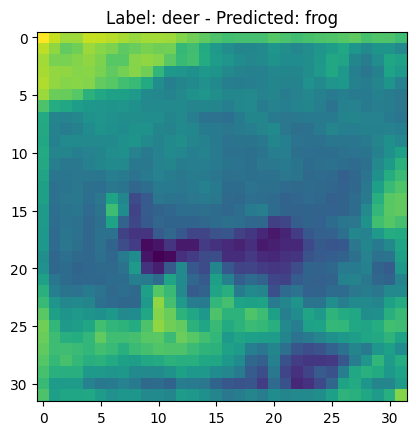

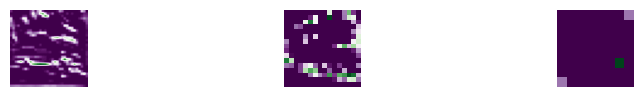

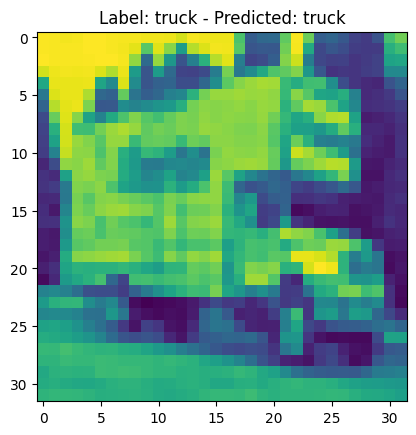

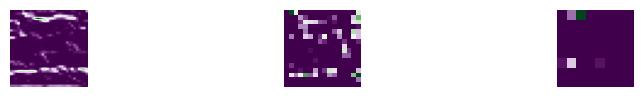

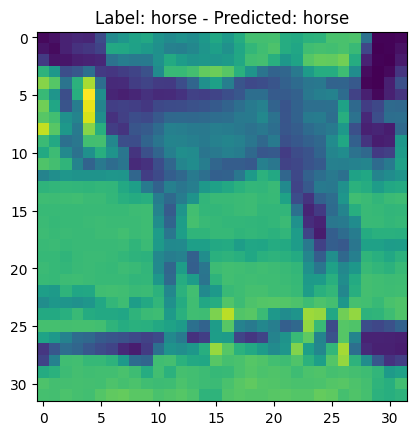

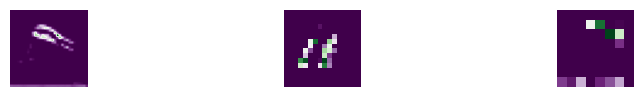

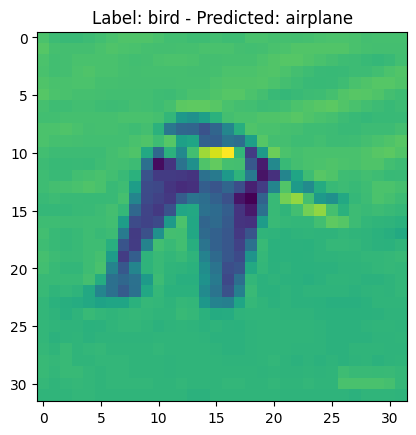

Accuracy for test set (all classes): 0.6971


In [15]:
# Create the dataloader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Create a confusion matrix
confusion_matrix = torch.zeros(10, 10)

# Create a dictionary to store the number of correct predictions per class
correct_predictions = {label: 0 for label in labels}

# Create a dictionary to store the number of predictions per class
total_predictions = {label: 0 for label in labels}

# Show the images and the predictions (first 10 images)
for i, (x, y) in enumerate(test_loader):
    # Get the prediction
    y_hat = model.forward(x, showImg=i < 10)

    # Get the predicted label
    _, yhat = torch.max(y_hat, dim=1)

    # Update the confusion matrix
    confusion_matrix[y, yhat] += 1
    
    y = y.item()

    # Update the number of correct predictions per class
    if y == yhat.item():
        correct_predictions[id2label[y]] += 1

    # Update the number of predictions per class
    total_predictions[id2label[y]] += 1

    # Show the image
    if i < 10:
        plt.imshow(x[0, 0])
        plt.title(f'Label: {id2label[y]} - Predicted: {id2label[yhat.item()]}')
        plt.show()

accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())
print(f'Accuracy for test set (all classes): {accuracy:.4f}')

### Matriz de confusión como mapa de calor

Text(0, 0.5, 'True label')

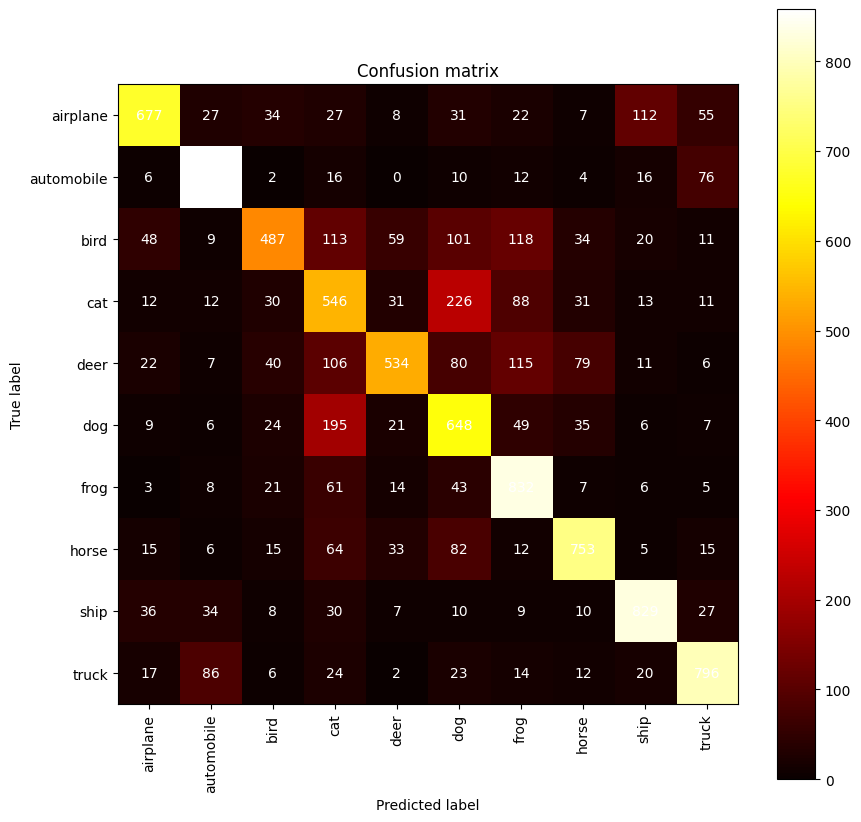

In [14]:
# Show the confusion matrix as a heatmap (color map) and show the number of correct predictions per class
# in the cell

# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap='hot')
plt.colorbar()
plt.xticks(range(10), labels, rotation=90)
plt.yticks(range(10), labels)
for i in range(10):
    for j in range(10):
        ax.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center', color='white')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')



# Precisión del modelo en función de las clases
Obtener la precisión del modelo para cada una de las clases

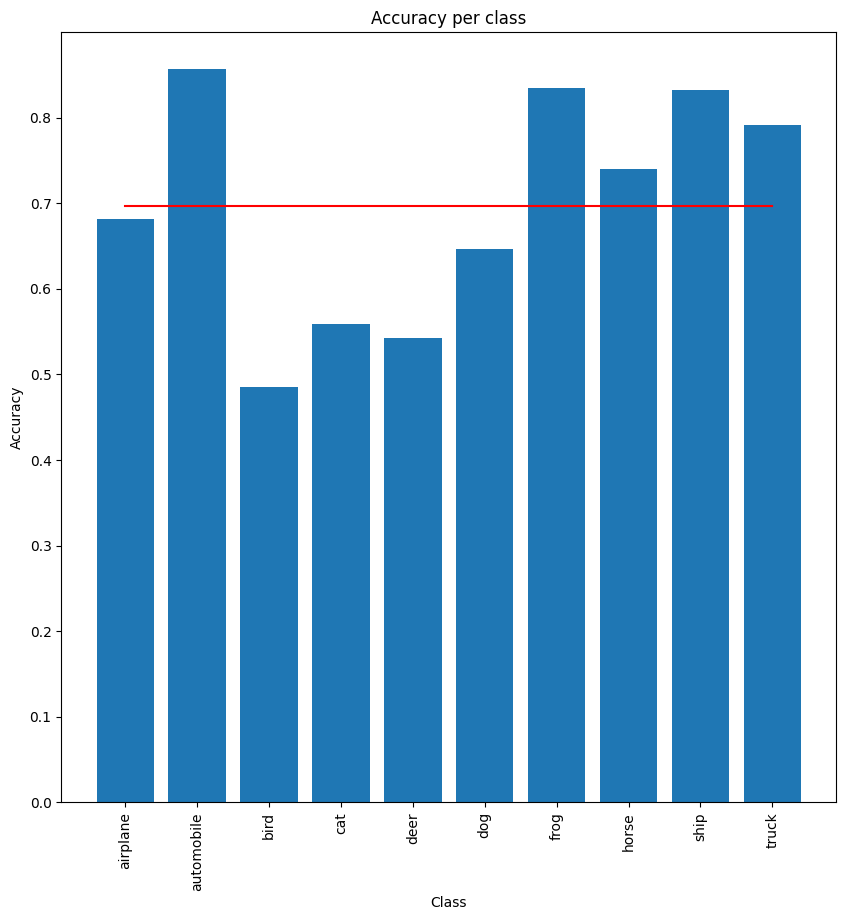

In [18]:
# Show the accuracy per class as bar plot and a line with the overall accuracy
# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(range(10), [correct_predictions[label] / total_predictions[label] for label in labels])
plt.plot([0, 9], [accuracy, accuracy], color='red')
plt.xticks(range(10), labels, rotation=90)
plt.title('Accuracy per class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()